In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install colorama

In [4]:

import os, warnings
import numpy as np
import PIL.Image as Image
#import matplotlib.pyplot as plt
from PIL import Image, ImageFile
from colorama import Fore
from fastai.vision.all import *
from fastai.metrics import accuracy
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix

import pathlib, os, torch, gc
import matplotlib.pyplot as plt
from fastai.vision.models import resnet50
from fastai.metrics import error_rate, accuracy
from fastai.vision.all import *

In [5]:
Image.MAX_IMAGE_PIXELS = 933120000 # Change the max pixels to avoid warnings
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [6]:

'''
trainPath = directory containing the train set
valid_pct = Percent of data used for validation set
bs = batch size
get_items = Function used extract the train set
get_y = Function used to classify the train set
item_tfms = Transforms to be performed on all of the data
batch_tfms = Transforms to be performed on each batch
'''

def loadData(trainPath, valid_pct, bs=None, get_items=get_image_files, get_y=parent_label,
             item_tfms=Resize(224, ResizeMethod.Pad, pad_mode='zeros'), batch_tfms=aug_transforms()):

    # parent_label --> simply gets the name of the folder a file is in

    loader = DataBlock(
        blocks = (ImageBlock, CategoryBlock),
        get_items = get_items,
        splitter = RandomSplitter(valid_pct=valid_pct, seed=24),
        get_y = get_y,
        item_tfms = item_tfms,
        batch_tfms = batch_tfms
    )
    dls = loader.dataloaders(trainPath, bs=bs)
    return dls

In [8]:
trainPath = '/content/drive/MyDrive/MalwareImageData'

dls = loadData(trainPath, valid_pct=0.2, bs=8, get_y=parent_label)

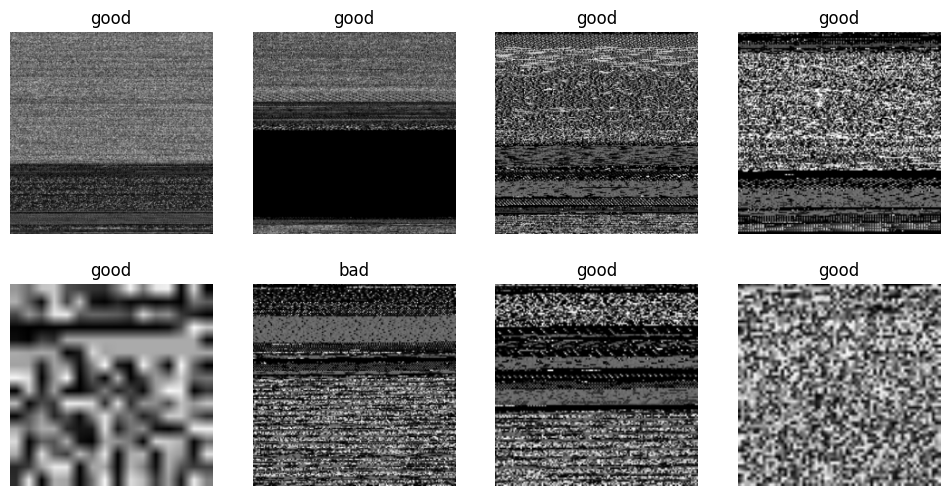

In [9]:
dls.valid.show_batch(max_n=8, nrows=2)

plt.show()

In [10]:
'''
dls  = Fastai DataLoaders object
arch = Architecture, e.g. resnet50
path = Path to where the trained model should be exported
epoch_ct = Number of iterations
metrics = Metrics to print while training
pretrained = Whether or not to use a pretrained model (False = Create model from scratch)
'''


def trainModel(dls, arch, path, epoch_ct=1, metrics=[error_rate, accuracy], pretrained=True):

    model   = cnn_learner(dls, arch, metrics=metrics, pretrained=pretrained)
    base_lr = model.lr_find()[0]

    model.fine_tune(epochs=epoch_ct, base_lr = base_lr)
    model.dls.train = dls.train
    model.dls.valid = dls.valid
    model.export(path)
    return model

/usr/local/lib/python3.11/dist-packages/fastai/vision/learner.py:303: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 90.5MB/s]


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.833185,0.586362,0.222222,0.777778,00:02


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.619211,0.701063,0.555556,0.444444,00:01
1,1.683869,1.084750,0.777778,0.222222,00:01
2,1.493584,1.299537,0.777778,0.222222,00:01
3,1.579694,1.055117,0.777778,0.222222,00:01
4,1.590157,1.103450,0.666667,0.333333,00:01
5,1.506844,0.904386,0.444444,0.555556,00:01
6,1.426465,0.987395,0.555556,0.444444,00:01
7,1.446816,0.813919,0.333333,0.666667,00:01
8,1.428834,0.835383,0.444444,0.555556,00:01
9,1.368420,0.845532,0.333333,0.666667,00:01


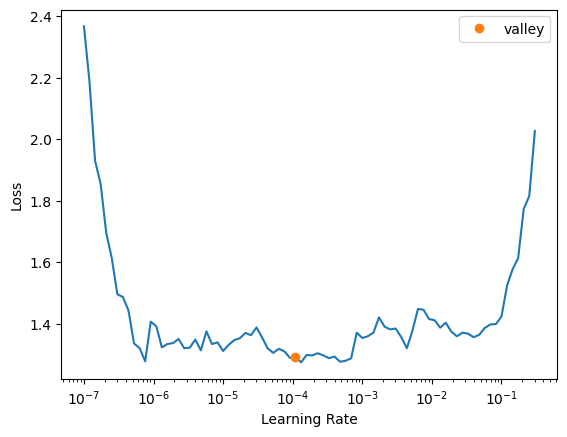

In [11]:
exportPath = '/content/drive/MyDrive/bestModel.pkl'

model = trainModel(dls, resnet50, path=exportPath, epoch_ct=10, metrics=[error_rate, accuracy], pretrained=True)

In [12]:
def confusionMatrix(isModel, model=None, y_true=None, y_pred=None, pos_label=None, neg_label=None):
    if(isModel):
        interp = ClassificationInterpretation.from_learner(model)
        interp.plot_confusion_matrix()
        plt.show()
    else:
        conf_matrix = confusion_matrix(y_true=y_true, y_pred=y_pred)
        fig, ax = plt.subplots(figsize=(7, 5.5))
        ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
        for i in range(conf_matrix.shape[0]):
            for j in range(conf_matrix.shape[1]):
                ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
        plt.xlabel('Predictions', fontsize=18)
        plt.ylabel('Actuals', fontsize=18)
        plt.title('Confusion Matrix', fontsize=18)
        ax.set_xticklabels([0, neg_label, pos_label])
        ax.set_yticklabels([0, neg_label, pos_label])
        plt.show()

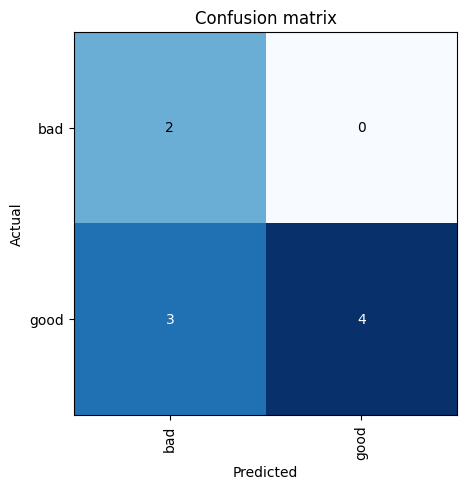

In [13]:
confusionMatrix(isModel=True, model=model)